In [1]:
!pip install yfinance tensorflow matplotlib scikit-learn --quiet

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = yf.download("AAPL", start="2015-01-01", end="2023-01-01")
print(data.head())

/tmp/ipython-input-4012955063.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261049  24.729272  23.821673  24.718176  212818400
2015-01-05  23.577568  24.110144  23.391167  24.030258  257142000
2015-01-06  23.579794  23.839424  23.218085  23.641928  263188400
2015-01-07  23.910431  24.010288  23.677428  23.788382  160423600
2015-01-08  24.829128  24.886824  24.121246  24.238858  237458000


In [3]:
close_prices = data['Close'].values.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_prices)

In [4]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)


In [5]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [6]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [7]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test,y_test))


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0260 - val_loss: 0.0024
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 4.1260e-04 - val_loss: 0.0019
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 3.1471e-04 - val_loss: 0.0016
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 3.2116e-04 - val_loss: 0.0019
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3.0961e-04 - val_loss: 0.0017
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 2.7692e-04 - val_loss: 0.0030
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 3.1196e-04 - val_loss: 0.0014
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 2.4731e-04 - val_loss: 0.0018
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 2.5577e-04 - val_loss: 0.0014
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 2.7631e-04 - val_loss: 0.0012


In [9]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [10]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

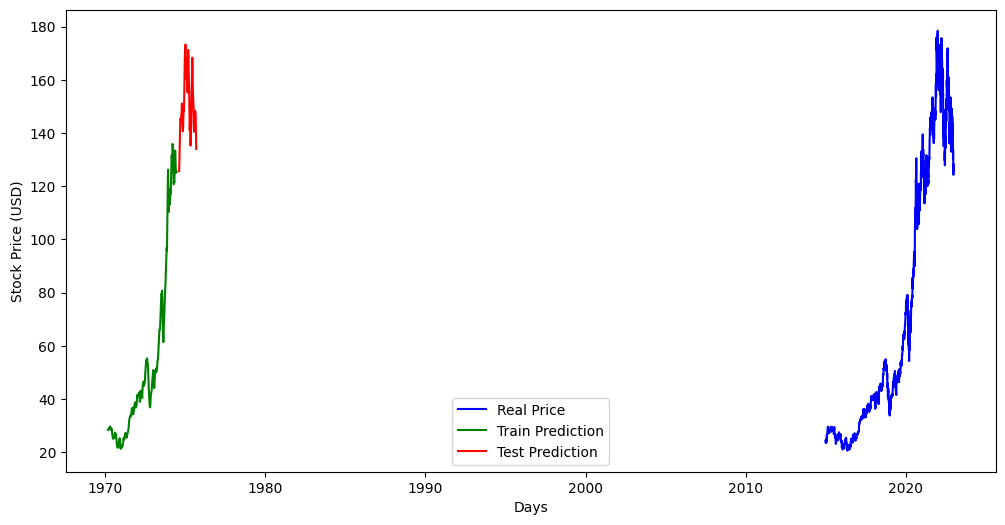

In [12]:
# STEP 7: Plot Results (Fixed)

# Create correct index ranges
train_range = np.arange(time_step, time_step + len(train_predict))
test_range = np.arange(time_step + len(train_predict) + (time_step), time_step + len(train_predict) + (time_step) + len(test_predict))

plt.figure(figsize=(12,6))
plt.plot(data['Close'], label="Real Price", color='blue')
plt.plot(train_range, train_predict, label="Train Prediction", color='green')
plt.plot(test_range, test_predict, label="Test Prediction", color='red')
plt.xlabel("Days")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()
